<h2>Per ogni istanza di ogni dominio voglio vedere quanti stati si sovrappongono: Due stati si sovrappongono se hanno una label iniziale diversa ma una label predetta uguale</h2>
<h2>La label predetta è compresa tra 0 e 1, ma posso riscalare nel range di valori originale grazie al min e max label salvati come data attribute. Questo rescaling però porta a valori decimali i quali vanno arrotondati all'intero più vicino</h2>

In [1]:
#encoding
from paper_code.parsing import get_datasets
from paper_code.encoding import Object2ObjectGraph, Object2AtomGraph, Atom2AtomGraph, ObjectPair2ObjectPairGraph
from paper_code.modelsTorch import get_compatible_model, get_tensor_dataset

#PyG
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GENConv, GINEConv, GATv2Conv, global_add_pool, global_mean_pool, global_max_pool

#torch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

#other
import os
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import optuna
from utils import extract_labels_from_samples, normalize_between_zero_and_one, check_edge_features_dim, add_zeros_edge_attributes, train_model, evaluate_model
from optuna_objectives import objective_GINEModel, objective_GENModel, objective_GAT
from models_architectures import GATModel, GENModel, GINEModel
from params import *

/usr/local/lib/python3.10/dist-packages/neuralogic/core/builder/builder.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
domains = ["blocks"]

In [3]:
predictions_folder_general = "./predictions_all_data/"

In [4]:
'''
Per ogni dominio e per ogni encoding carico i best_params e faccio il training del modello che poi utilizzo per predirre tutti i dati (data_list) e non solo il test_set
'''
for domain in domains:
    print(f"STARTING DOMAIN {domain}")
    domain_folder = domain_folder_root + domain + "/"
    predictions_folder = predictions_folder_general + domain.upper() + "/"
    instances = get_datasets(domain_folder, descending=False)
    for encoding in encodings_list:
        print(f"STARTING ENCODING {encoding}")
        #PREPROCESSING
        data_list = []
        for instance in instances:
            samples = instance.get_samples(eval(encoding))
            labels = extract_labels_from_samples(samples)
            norm_labels = normalize_between_zero_and_one(labels)
            #covert samples to PyG data format
            tensor_dataset = get_tensor_dataset(samples)
            #if there are no edge_attr add zeros edge_attributes in order to not have errors during training.
            # !!! N.B. !!! valutare di rimuovere questi pochi stati senza edge_Attr
            num_edge_features = check_edge_features_dim(tensor_dataset)

            # add zeros edge attributes if there are no edges
            tensor_dataset = add_zeros_edge_attributes(tensor_dataset, num_edge_features)

            #add_custom label and min/max value of the label in order to be able to transform prediction to original label
            min_label = np.min(labels)
            max_label = np.max(labels)
            for i, data in enumerate(tensor_dataset):
                custom_label = norm_labels[i]
                data.custom_label = custom_label
                data.min_label = min_label
                data.max_label = max_label
                data.instance_name = instance.name
            data_list.extend(tensor_dataset)


        #CHECK PREPROCESSING CORRECTNESS
        features = data_list[0].num_features
        process_correct = True
        for data in data_list:
            if data.num_features != features:
                print(f"Different number of features! --> {data.num_features}")
                process_correct = False
                raise Exception("Edge features with different dimension!")

        #TRAIN TEST SPLIT
        train_list, test_list = train_test_split(data_list, random_state=seed, test_size=0.1)

        #TEST
        # creating a df to store predictions
        list_df = []
        for item in data_list:
            list_df.append({"item":item,
                            "Label":item.custom_label.item()})
        df = pd.DataFrame(list_df)

        #test
        for model_type in ["GATModel","GENModel","GINEModel"]:
            print(f"--> Starting {model_type} test")
            torch.manual_seed(seed)
            #load study and best trial
            optuna_file = f"./optuna/{encoding}/{domain.upper()}/{model_type}_study.pkl"
            study = joblib.load(optuna_file)
            best_trial = study.best_trial
            #get loaders
            train_loader = DataLoader(train_list, batch_size=best_trial.params["batch_size"], shuffle=True)
            test_loader = DataLoader(test_list, batch_size=best_trial.params["batch_size"], shuffle=True)

            node_in_dim = train_loader.dataset[0].num_node_features
            num_edge_features = train_loader.dataset[0].num_edge_features
            output_dim = 1   

            if model_type == "GINEModel":
                model = GINEModel(node_in_dim=node_in_dim,
                                 hidden_dim=best_trial.params["hidden_dim"],
                                 output_dim=output_dim,
                                 fc_hidden_dim= best_trial.params["fc_hidden_dim"], 
                                 num_edge_features = num_edge_features, 
                                 readout=best_trial.params["readout"],
                                 dropout_rate=best_trial.params["dropout_rate"],
                                 training=False
                                 )
            if model_type == "GENModel":
                model = GENModel(node_in_dim=node_in_dim,
                                 hidden_dim=best_trial.params["hidden_dim"],
                                 output_dim=output_dim,
                                 fc_hidden_dim= best_trial.params["fc_hidden_dim"],
                                 hidden_layers=best_trial.params["hidden_layers"],
                                 aggregation_function=best_trial.params["aggregation_function"], 
                                 num_edge_features = num_edge_features, 
                                 readout=best_trial.params["readout"],
                                 dropout_rate=best_trial.params["dropout_rate"],
                                 training=False
                                 )
            if model_type == "GATModel":
                model = GATModel(node_in_dim=node_in_dim,
                                 hidden_dim=best_trial.params["hidden_dim"],
                                 output_dim=output_dim,
                                 fc_hidden_dim= best_trial.params["fc_hidden_dim"],
                                 num_edge_features=num_edge_features,
                                 dropout_rate=best_trial.params["dropout_rate"],
                                 readout=best_trial.params["readout"],
                                 hidden_layers=best_trial.params["hidden_layers"],
                                 activation_function=best_trial.params["activation_function"],
                                 heads=best_trial.params["heads"],
                                 training=False
                                 )
            optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params["lr"])
            criterion = nn.L1Loss()

            trained_model = train_model(model, train_loader, optimizer, criterion, epochs, verbose=1)
            mae = evaluate_model(trained_model, test_loader)

            # memorizzo le prediction
            predictions = []
            with torch.no_grad():
                for data in data_list:
                    out = trained_model(data)
                    predictions.append(out.item())
            df[model_type] = predictions
            print(f" Best trial had {best_trial.value} mean MAE on validation set \n the {model_type} model created with the best values have {mae} MAE on the test set")
            print("")

        #SAVE PREDICTIONS DF
        os.makedirs(predictions_folder, exist_ok=True)
        prediction_df = predictions_folder + f"{encoding}.csv"
        df.to_csv(prediction_df, sep=";", index=False)

STARTING DOMAIN blocks
STARTING ENCODING Object2ObjectGraph
--> Starting GATModel test
Epoch 1, Loss (average per batch): 0.2232447483111173
Epoch 2, Loss (average per batch): 0.21026585972867906


KeyboardInterrupt: 

In [ ]:
#RESCALING PREDICTIONS
dict_results = {}
for domain in domains:
    print(f"STARTING DOMAIN {domain}")
    dict_results[domain] = {}
    domain_folder = domain_folder_root + domain + "/"
    predictions_folder = predictions_folder_general + domain.upper() + "/"
    for encoding in encodings_list:
        df = pd.read_csv(predictions_folder + f"{encoding}.csv", sep=";")
        # GET ORIGINAL LABEL
        df["original_label"] = df["item"].apply(lambda x: eval(x).y)
        #GET INSTANCE NAME
        df["instance_name"] = df["item"].apply(lambda x: eval(x).instance_name)
        #RESCALING OF PREDICTIONS AND ROUND TO INT
        for model_type in ["GATModel", "GENModel", "GINEModel"]:
            new_column_name = model_type + "_rescaled"
            df[new_column_name] = df.apply(
                lambda x: x[model_type] * (eval(x["item"]).max_label - eval(x["item"]).min_label) + eval(x["item"]).min_label, axis=1
            )
            df[new_column_name] = df[new_column_name].round()
        os.makedirs(predictions_folder, exist_ok=True)
        prediction_df = predictions_folder + f"{encoding}_rescaled.csv"
        df.to_csv(prediction_df, sep=";", index=False)

STARTING DOMAIN blocks
STARTING DOMAIN logistics
STARTING DOMAIN rovers
STARTING DOMAIN sokoban


In [ ]:
#ANALISI SOVRAPPOSIZIONI
# elaboro ogni combinazione encoding-istanza-modello e calcolo le sovrapposizione che poi inserisco un dizionario
# Il dizionario ha struttura: dict_results[domain][encoding][instance_name][model] = sovrapposizioni_count
dict_results = {}
for domain in domains:
    print(f"STARTING DOMAIN {domain}")
    dict_results[domain] = {}
    domain_folder = domain_folder_root + domain + "/"
    predictions_folder = predictions_folder_general + domain.upper() + "/"
    instances = get_datasets(domain_folder, descending=False)
    for encoding in encodings_list:
        dict_results[domain][encoding] = {}
        df = pd.read_csv(predictions_folder + f"{encoding}_rescaled.csv", sep=";")
        #round prediction column to 3 decimanls
        df[['GATModel', 'GENModel', 'GINEModel']] = df[['GATModel', 'GENModel', 'GINEModel']].round(3)
        instance_names = list(df["instance_name"].unique())
        for instance_name in instance_names:
            df_filtered_instance = df[df["instance_name"]==instance_name]
            dict_results[domain][encoding][instance_name] = {}
            for model in ["GATModel", "GENModel", "GINEModel"]:
                print(f"operating on: {encoding}-{instance_name}-{model}")
                dict_results[domain][encoding][instance_name][model] = {}
                #cerco le sovrapposizioni
                sovrapposizioni_count = 0
                for i in range(df_filtered_instance.shape[0]):
                    first_state_original_label = df_filtered_instance.iloc[i]["Label"]
                    prediction_column = model
                    prediction_first_state = df_filtered_instance.iloc[i][prediction_column]
                    for j in range(i,df_filtered_instance.shape[0]):
                        second_state_original_label = df_filtered_instance.iloc[j]["Label"]
                        prediction_second_state = df_filtered_instance.iloc[j][prediction_column]
                        if prediction_first_state == prediction_second_state:
                            if first_state_original_label != second_state_original_label:
                                sovrapposizioni_count += 1
                dict_results[domain][encoding][instance_name][model] = sovrapposizioni_count

STARTING DOMAIN blocks
operating on: Object2ObjectGraph-probBLOCKS-10-0.txt-GATModel
operating on: Object2ObjectGraph-probBLOCKS-10-0.txt-GENModel
operating on: Object2ObjectGraph-probBLOCKS-10-0.txt-GINEModel
operating on: Object2ObjectGraph-probBLOCKS-10-1.txt-GATModel
operating on: Object2ObjectGraph-probBLOCKS-10-1.txt-GENModel
operating on: Object2ObjectGraph-probBLOCKS-10-1.txt-GINEModel
operating on: Object2ObjectGraph-probBLOCKS-10-2.txt-GATModel
operating on: Object2ObjectGraph-probBLOCKS-10-2.txt-GENModel
operating on: Object2ObjectGraph-probBLOCKS-10-2.txt-GINEModel
operating on: Object2ObjectGraph-probBLOCKS-11-0.txt-GATModel
operating on: Object2ObjectGraph-probBLOCKS-11-0.txt-GENModel
operating on: Object2ObjectGraph-probBLOCKS-11-0.txt-GINEModel
operating on: Object2ObjectGraph-probBLOCKS-11-1.txt-GATModel
operating on: Object2ObjectGraph-probBLOCKS-11-1.txt-GENModel
operating on: Object2ObjectGraph-probBLOCKS-11-1.txt-GINEModel
operating on: Object2ObjectGraph-probBLOCK

In [ ]:
dict_results

{'blocks': {'Object2ObjectGraph': {'probBLOCKS-10-0.txt': {'GATModel': 7,
    'GENModel': 18,
    'GINEModel': 13},
   'probBLOCKS-10-1.txt': {'GATModel': 64, 'GENModel': 28, 'GINEModel': 14},
   'probBLOCKS-10-2.txt': {'GATModel': 38, 'GENModel': 47, 'GINEModel': 25},
   'probBLOCKS-11-0.txt': {'GATModel': 18, 'GENModel': 47, 'GINEModel': 23},
   'probBLOCKS-11-1.txt': {'GATModel': 30, 'GENModel': 34, 'GINEModel': 17},
   'probBLOCKS-11-2.txt': {'GATModel': 25, 'GENModel': 31, 'GINEModel': 20},
   'probBLOCKS-12-0.txt': {'GATModel': 25, 'GENModel': 40, 'GINEModel': 21},
   'probBLOCKS-12-1.txt': {'GATModel': 27, 'GENModel': 78, 'GINEModel': 18},
   'probBLOCKS-13-0.txt': {'GATModel': 20, 'GENModel': 10, 'GINEModel': 13},
   'probBLOCKS-13-1.txt': {'GATModel': 11, 'GENModel': 8, 'GINEModel': 7},
   'probBLOCKS-14-0.txt': {'GATModel': 24, 'GENModel': 12, 'GINEModel': 5},
   'probBLOCKS-14-1.txt': {'GATModel': 5, 'GENModel': 5, 'GINEModel': 4},
   'probBLOCKS-15-0.txt': {'GATModel': 15, 

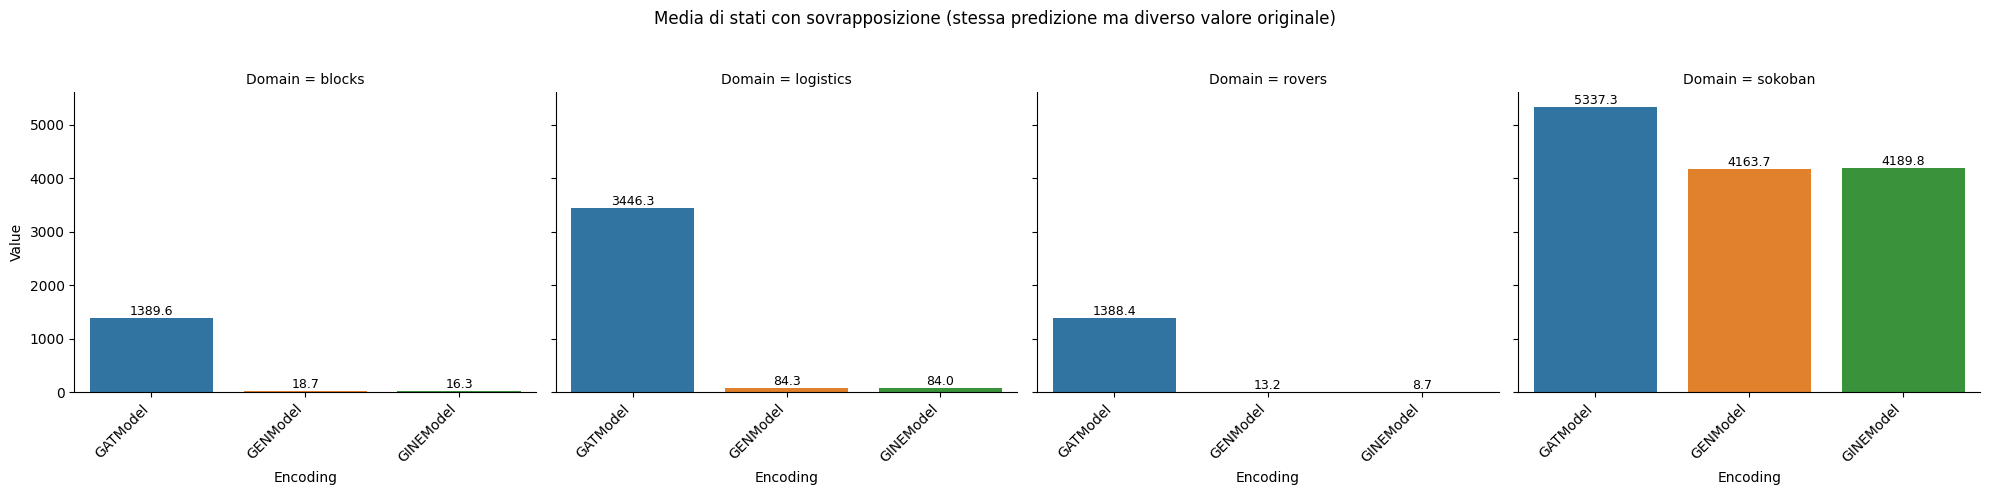

In [ ]:
# calcolo della media: attenzione perchè ogni istanza ha la sua complessità
sovrapposizione_stati_media = {}
for domain in dict_results.keys():
    sovrapposizione_stati_media[domain] = {}
    for encoding, dict_instances_models in dict_results[domain].items():
        sovrapposizione_stati_media[domain][encoding] = {}
        for model in list(list(dict_instances_models.values())[0].keys()):
            media_sovrapposizione_modello = np.mean([x[model] for x in dict_instances_models.values()])
            sovrapposizione_stati_media[domain][encoding][model] = media_sovrapposizione_modello
#ora passo da dict a df per facilitare il plot con sns
df_sovrapposizione_media = pd.DataFrame.from_dict(
    {(domain, encoding): models for domain, encodings in sovrapposizione_stati_media.items() for encoding, models in encodings.items()},
    orient='index'
)

# Reset dell'indice per ottenere colonne separate per "domain" e "graph"
df_sovrapposizione_media.index.names = ['Domain', 'Encoding']
df_sovrapposizione_media = df_sovrapposizione_media.reset_index()
# Melt the DataFrame for easier plotting
df_melted = df_sovrapposizione_media.melt(id_vars=["Domain", "Encoding"], var_name="Model", value_name="Value")
g = sns.catplot(data=df_melted,
            kind="bar",
            x="Model",
            y="Value",
            hue="Model",
            col="Domain",
            errorbar=None
            )
# Add values over each bar
for ax in g.axes.flat:  # Iterate through each subplot
    for bar in ax.patches:  # Iterate through each bar
        # Get the height and position of the bar
        bar_height = bar.get_height()
        bar_x = bar.get_x() + bar.get_width() / 2
        # Annotate the bar with its height
        ax.text(
            bar_x, bar_height, f'{bar_height:.1f}',  # Format to 1 decimal place
            ha='center', va='bottom', fontsize=9, color='black'
        )
# Adjust the plot
plt.suptitle("Media di stati con sovrapposizione (stessa predizione ma diverso valore originale)")
g.set_axis_labels("Encoding", "Value")
g.set_xticklabels(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the suptitle
plt.show()

In [ ]:
#Partendo dal dizionario precedentemente creato, raggruppo i risultati dei modelli relativi alla combinazione domanin-encoding.instance sulla stessa riga
# Inoltre ordino il dfin base a domin-instance per avere poi un plot più accurato (in ordine crescente di difficoltà nel dominio)
from natsort import natsorted
list_df = []
for domain in dict_results.keys():
    for encoding, dict_instances_models in dict_results[domain].items():
        for instance, models in dict_instances_models.items():
            list_df.append({"domain":domain,
                           "encoding":encoding,
                           "instance":instance,
                           "GATModel":models["GATModel"],
                           "GENModel":models["GENModel"],
                           "GINEModel":models["GINEModel"]})
df_sovrapposizioni = pd.DataFrame(list_df)
df_sovrapposizioni = df_sovrapposizioni.loc[natsorted(df_sovrapposizioni.index, key=lambda x: df_sovrapposizioni.loc[x, ["domain","instance"]])]
df_sovrapposizioni

,domain,encoding,instance,GATModel,GENModel,GINEModel
27,blocks,Object2ObjectGraph,probBLOCKS-4-0.txt,33,29,26
72,blocks,Object2AtomGraph,probBLOCKS-4-0.txt,4775,67,71
117,blocks,Atom2AtomGraph,probBLOCKS-4-0.txt,29,23,28
28,blocks,Object2ObjectGraph,probBLOCKS-4-1.txt,94,88,83
73,blocks,Object2AtomGraph,probBLOCKS-4-1.txt,4675,81,96
...,...,...,...,...,...,...
332,sokoban,Object2AtomGraph,p28.txt,3283,48,43
361,sokoban,Atom2AtomGraph,p28.txt,42,38,46
304,sokoban,Object2ObjectGraph,p29.txt,989,80,1073
333,sokoban,Object2AtomGraph,p29.txt,2174,861,1171


C:\Users\dinema\AppData\Local\Temp\ipykernel_10356\4028589197.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels,rotation=90)


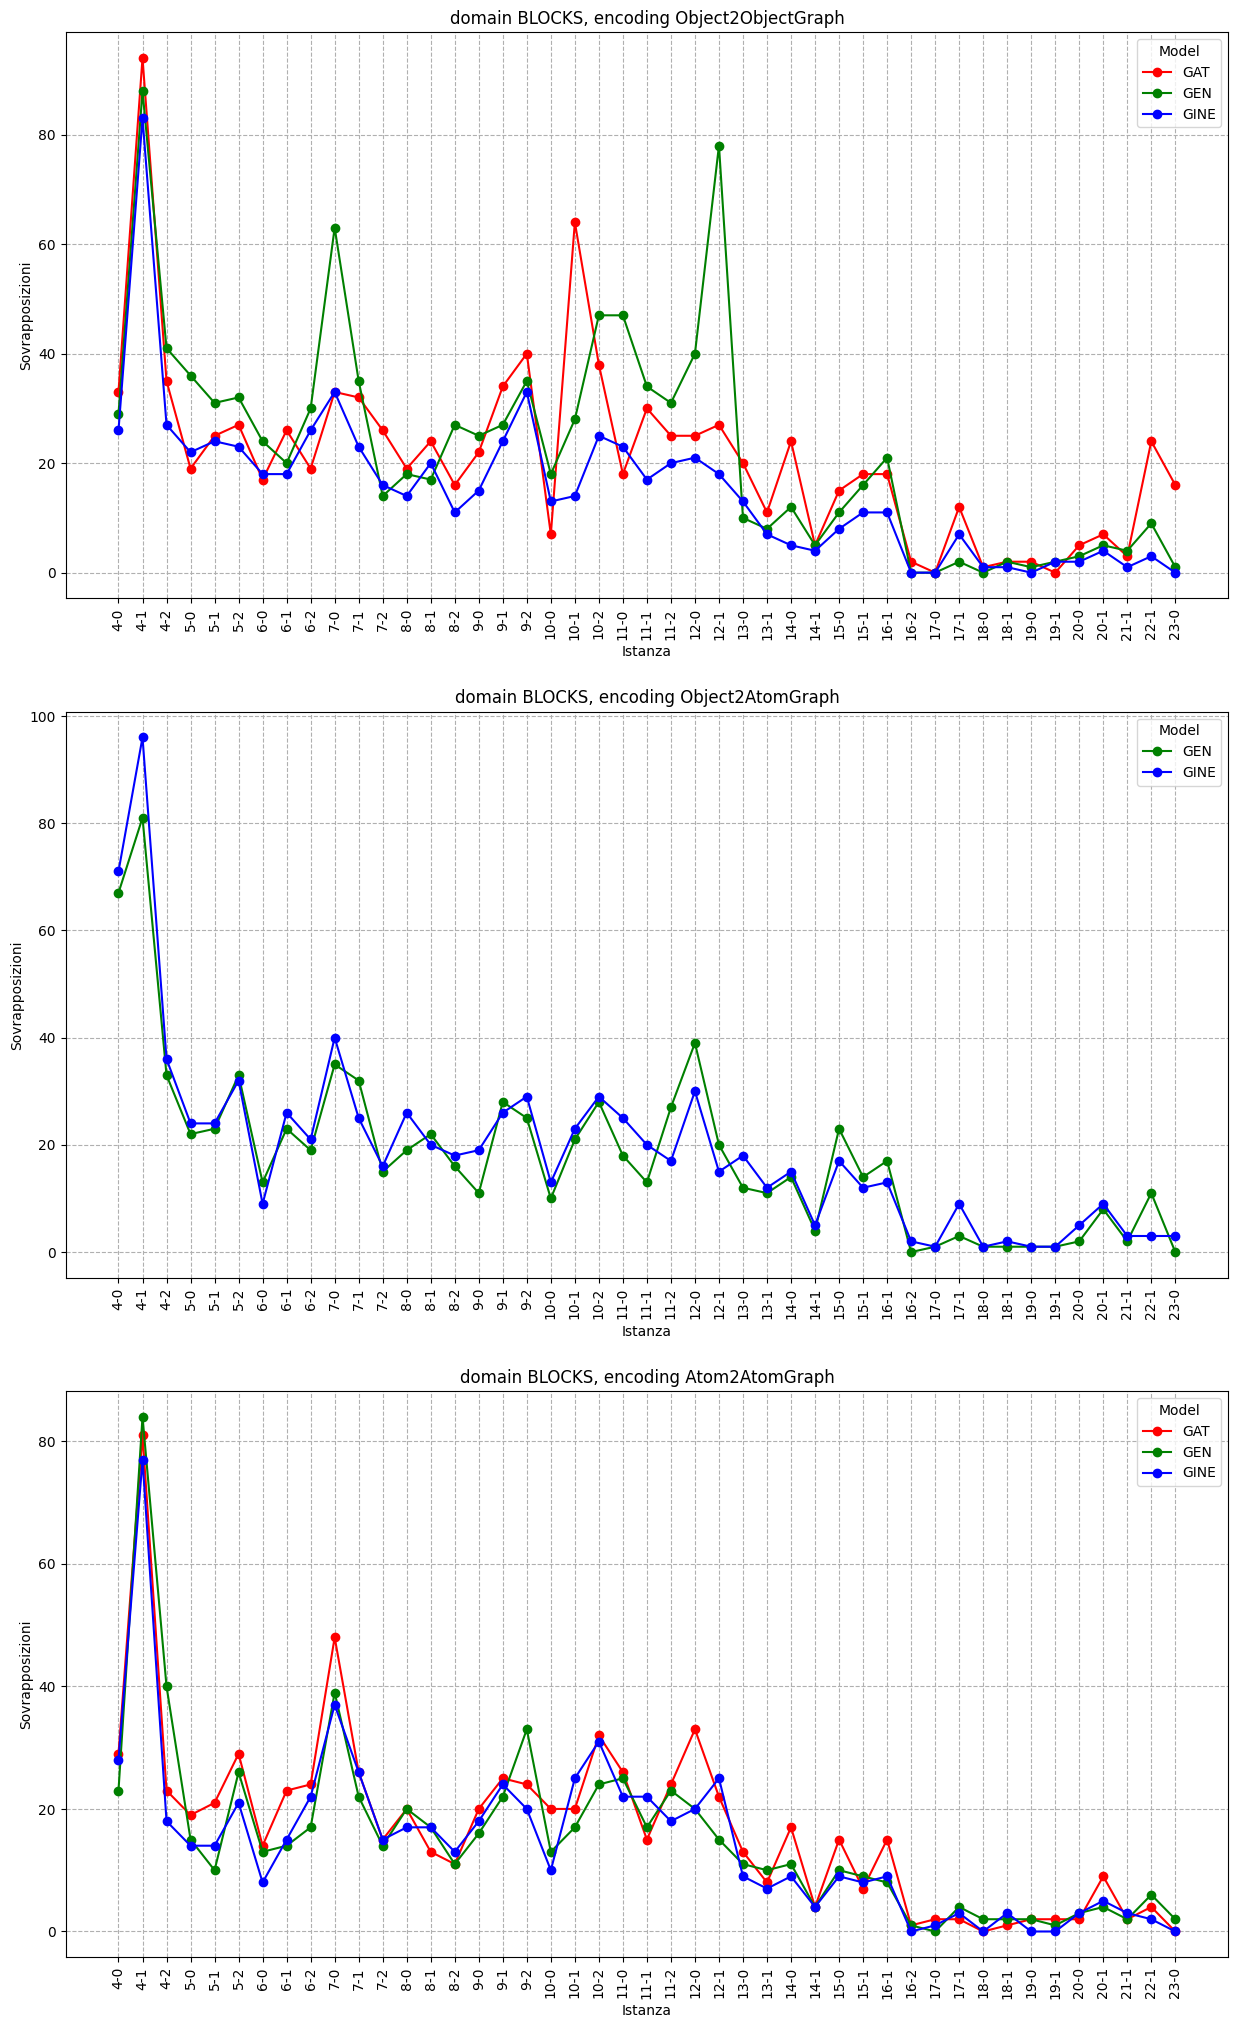

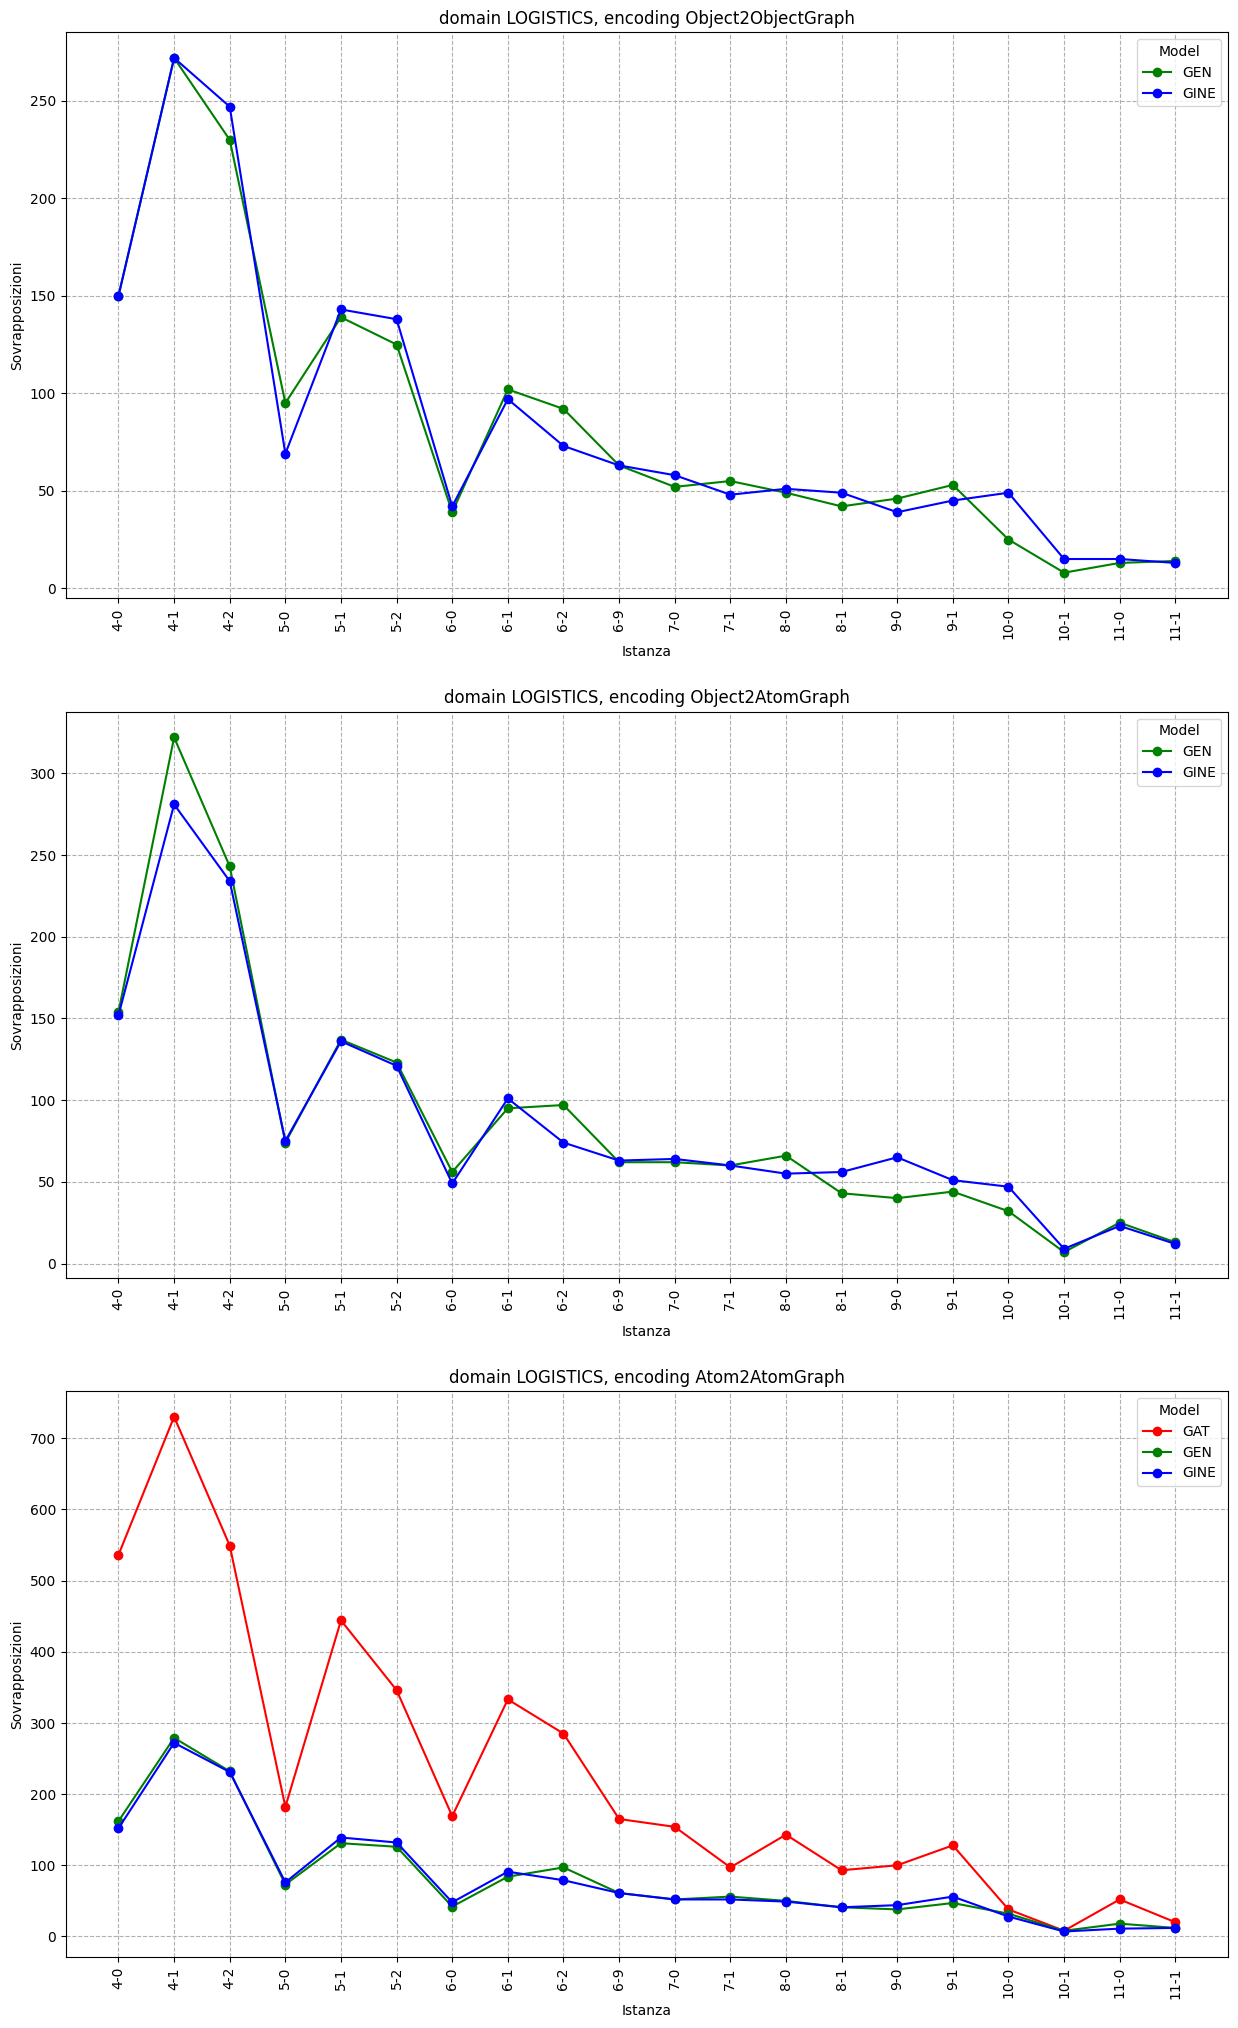

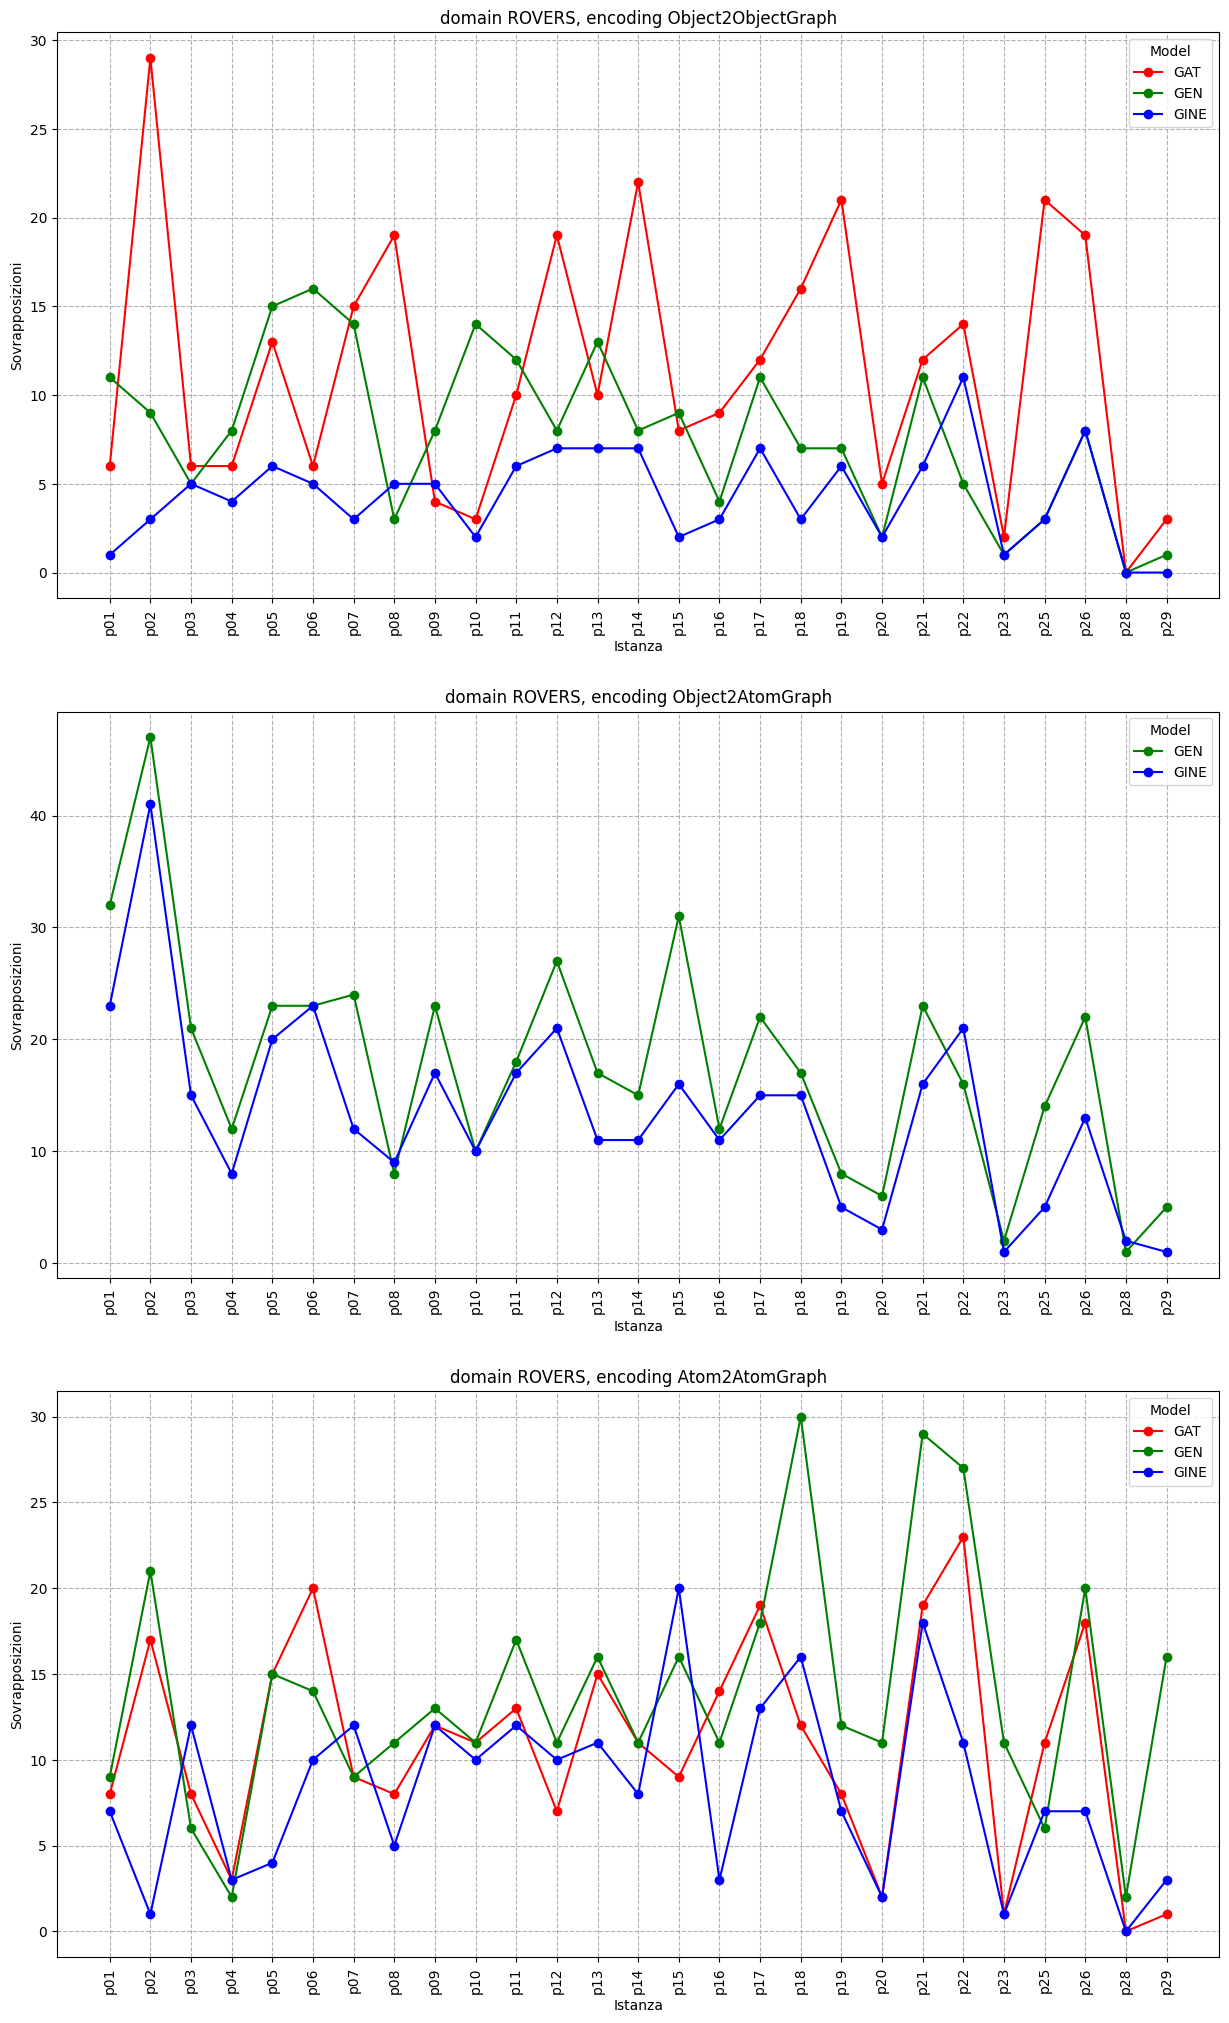

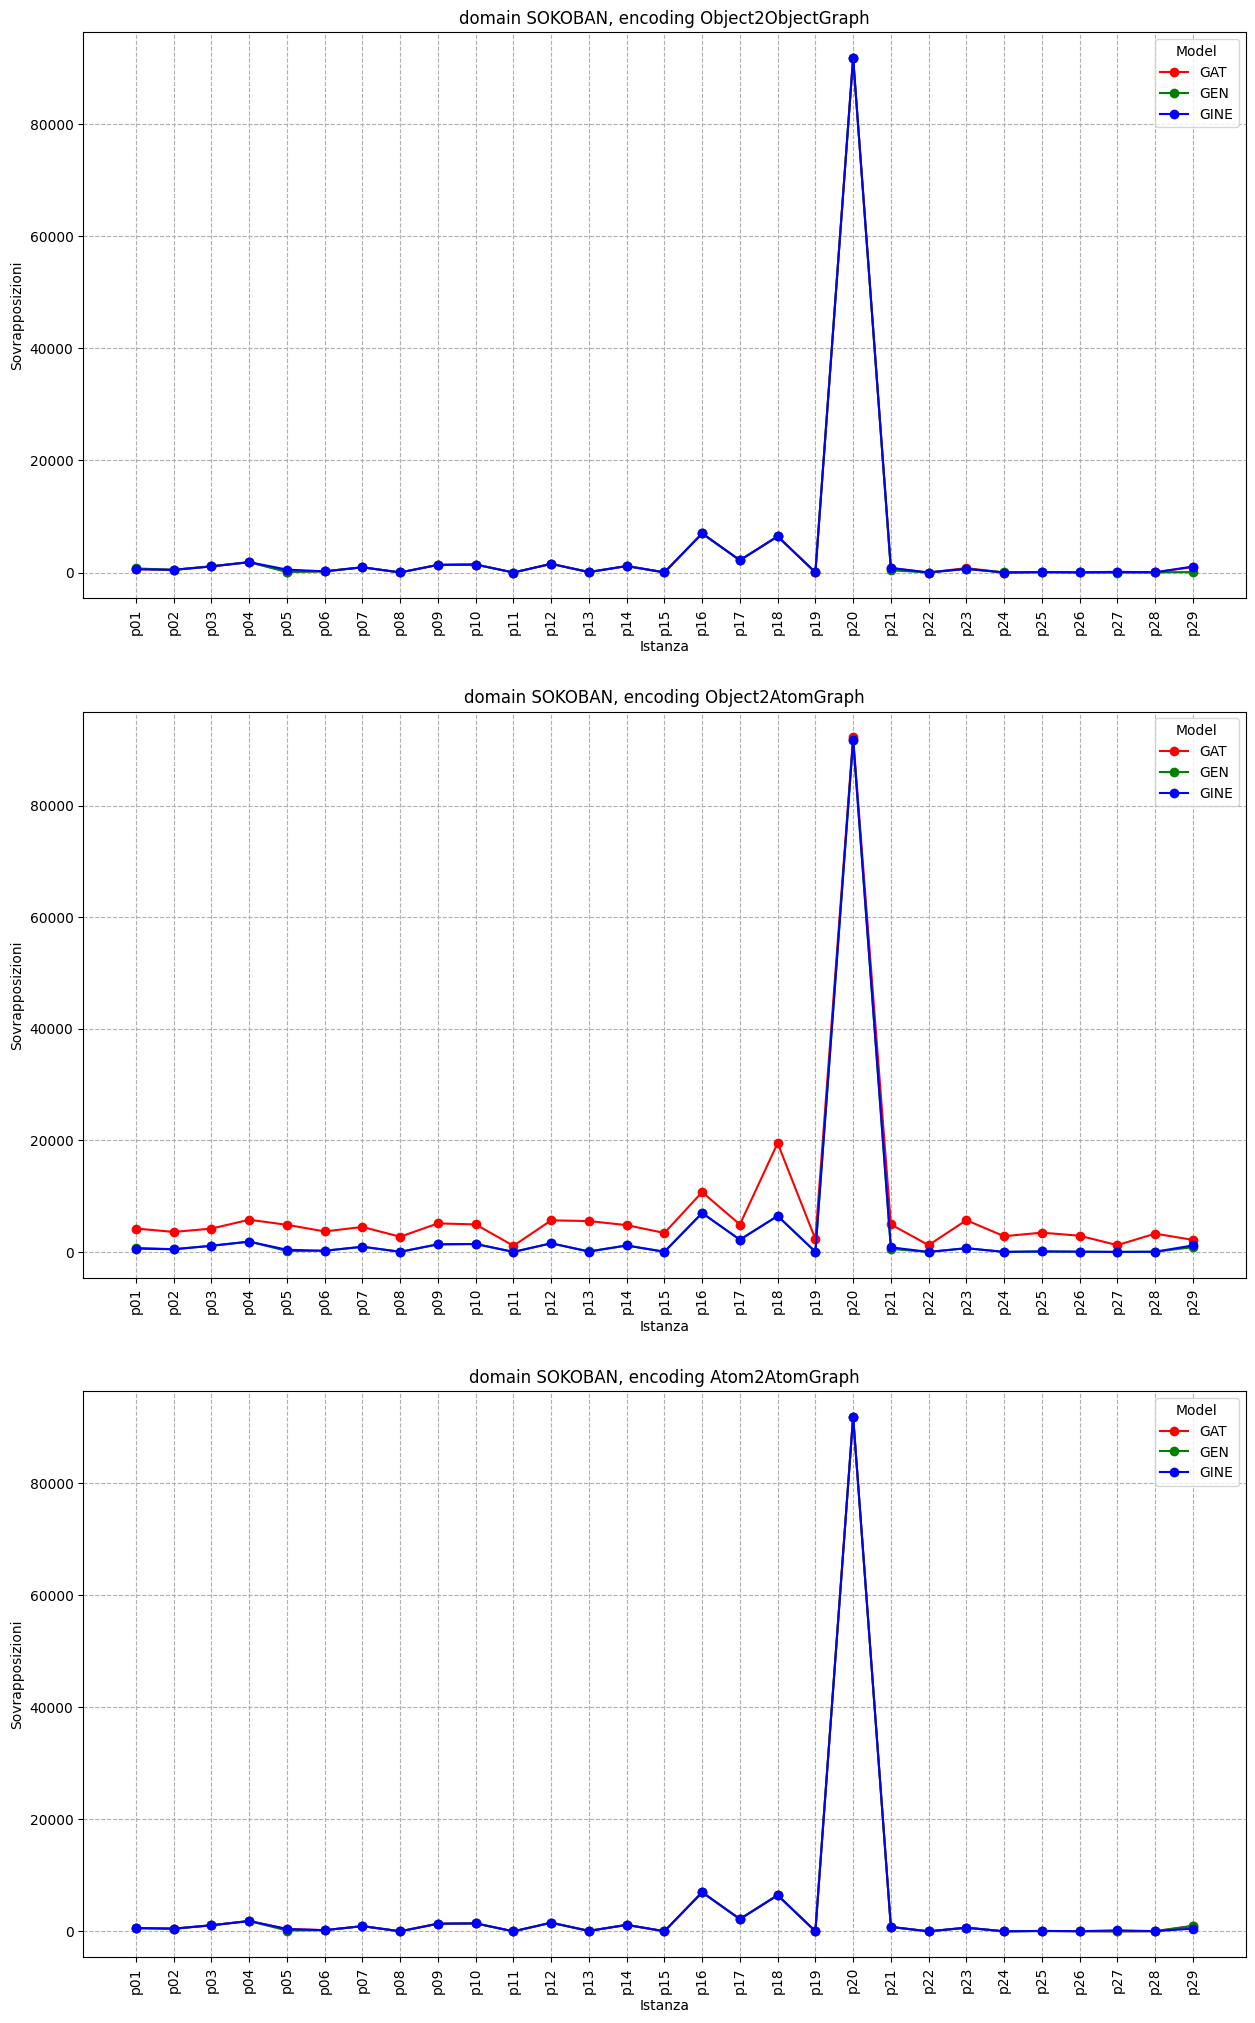

In [ ]:
for domain in df_sovrapposizioni["domain"].unique():
    fig, ax = plt.subplots(3,1,figsize=(15,25))
    for i, encoding in enumerate(df_sovrapposizioni["encoding"].unique()):
        df_filtered = df_sovrapposizioni[(df_sovrapposizioni["domain"]==domain) & (df_sovrapposizioni["encoding"]==encoding)]
        labels = df_filtered["instance"]
        labels = [x.replace(".txt","") for x in labels]
        labels = ["-".join(x.split("-")[1:]) if "-" in x else x for x in labels]
        #since GAT has some poor performance, I plot only  when it is useful (altrimenti rovina la scala del grafico)
        #plotto GAT solo se la media delle sovrapposizione è minore di X*media((media_sovrapp_GEN),(media_sovrapp_GIN))
        if np.mean(df_filtered["GATModel"]) <= 5* np.mean((np.mean(df_filtered["GENModel"]),np.mean(df_filtered["GINEModel"]))):
            ax[i].plot(df_filtered["instance"], df_filtered["GATModel"], marker="o", color="red", label="GAT")
        ax[i].plot(df_filtered["instance"], df_filtered["GENModel"], marker="o", color="green", label="GEN")
        ax[i].plot(df_filtered["instance"], df_filtered["GINEModel"], marker="o", color="blue", label="GINE")
        ax[i].set_xlabel("Istanza")
        ax[i].set_ylabel("Sovrapposizioni")
        ax[i].set_xticklabels(labels,rotation=90)
        ax[i].legend(title="Model")
        ax[i].set_title(f"domain {domain.upper()}, encoding {encoding}")
        ax[i].grid(axis="both", linestyle="--")
    plt.savefig(f"./results_analysis/sovrapposizione_stati/sovrapposizione_stati_{domain.upper()}.png")
    plt.show()